# CS166 - Traffic Simulation 
#### Juan Castro Fernandez

## Part 1 - Traffic Jams on a circular road

In [12]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [13]:
class SingleLane:
    def __init__(self, length = 100, density = 0.2, max_vel = 5, p_slowdown = 0.5, initial_config = False):
        self.n = length    #road length is stored as n
        self.density = density
        self.max_vel = max_vel   
        self.p_slowdown = p_slowdown  #probability of slowing down in the update timestep
        
        #state of the road (initialized as all 0s)
        self.state = np.zeros(length)
        
        #randomly assigning initial empty locations (-1s) according to the density
        init_empty_loc = np.random.choice(list(range(length)),int((1-density)*length), replace=False)
        for loc in init_empty_loc:
            self.state[loc] = -1
    
    def update(self): 
        #keep track of the number of flows between n-1 and 0 for this simulation step
        flows = 0
        #The moving cars step is done first with the aim to replicate the visualization in the Nagel, K.
        #and Schreckenberg, M. that shows the velocities of the cars right before they move
        
        #separate copy for the new state (starting with all empty cells [-1s])
        new_state = np.array([-1]*self.n)
        
        #updating car positions based on the current velocities
        for i in range(self.n):
            if self.state[i] >= 0: #if there's a car in the cell
                
                #check whether the car moves from cell n-1 to cell 0
                if i+self.state[i] >= self.n:
                       flows+=1 #if so, add one to the count of flows
                
                #update new position
                new_state[int((i+self.state[i])%self.n)]=self.state[i]
        
        #after all new positions have been computed, update the current state of the road
        self.state = new_state
        
        #updating velocities
        for i in range(self.n):
            if self.state[i] >= 0:
                #variable of the new vel that contains copy of current velocity that will be updated by rules 1-4
                new_vel = self.state[i]
                
                #rule 1 (I only check for the distance between the current and next car in rule 2)
                if self.state[i] < self.max_vel:
                    new_vel+=1

                #rule 2
                #check distance
                distance = self.max_vel # assume there's enough space to go at max_vel 
                for d in range(1,self.max_vel): #check for all cells between the next and the one at distance max_vel
                    if self.state[int((i+d)%self.n)] != -1:
                    #if car is found d steps ahead, update distance to d-1
                        distance = d-1
                        #break the loop because you don't care about the next potential cars ahead
                        break
                if new_vel > distance:
                    #slowdown to make sure you don't crash (if necessary)
                    new_vel = distance

                #rule 3
                if new_vel >= 1:
                    if np.random.random() < self.p_slowdown:
                        #randomly slowing down
                        new_vel-=1
                        
                #update velocity of car
                self.state[i] = new_vel 
                
        return flows #return the number of flows in the update step (this value is either 0 or 1)
    
    def display(self):
        print(''.join('.' if x==-1 else str(int(x)) for x in self.state))

In [14]:
#running simulation for 20 steps with density = 0.2
oneLane = SingleLane()
oneLane.display()

....0......0...0.0.................00....0....0..0...000..0..0.........0...00........0....0......0..


In [15]:
for i in range(20):
    oneLane.display()
    oneLane.update()

....0......0...0.0.................00....0....0..0...000..0..0.........0...00........0....0......0..
....0......1...1.1.................01....0....0..0...001..1..0.........0...00........0....0......1..
....1.......1...1.2................0.2...1....0..1...01.2..0.1.........0...00........1....1.......2.
2....1.......2...2..3..............0...2..2...1...1..1.1..01..1........1...01.........1....2........
..2...1........3...3...3...........1.....1..2..1...2..0.0.1.2..1........2..0.2.........2.....3......
....1..2..........2...3...3.........1.....1...1.1....01.0..1..1.2.........01...3.........3......4...
5....2...3..........2....2...4.......2.....1...0.1...0.00...1..1..3.......1.1.....3.........4.......
.....1.3....3.........3....3.....4.....3....1..1..2..0.01....2..2....3.....0.1.......3..........4...
5.....2...3....4.........3....4......5....1..1..1...01.0.2.....1..2.....2..1..2.........3...........
.....2..2....3.....4........3.....4.......02..1..2..1.00...3....1...3.....0.1...2..........

In [16]:
#obtain de q_value: the time-averaged flow between cell n-1 and cell 0, given density p
def get_q(p = 0.1, n_sims =20, timesteps = 200, t_0 = 100, display = False, max_velocity = 5, p_slow = 0.5, multilane = False):
    if not multilane:
        sim = SingleLane(density = p, max_vel = max_velocity, p_slowdown = p_slow)
        print('sim is single lane')
    else:
        sim = MultipleLanes(density = p, max_vel = max_velocity, p_slowdown = p_slow)
        print('sim is multilane')
    #list keep track of flows for each simulation
    flows = []
    for i in range(n_sims):
        flow_counter = 0
        #simulate without collecting data for the first t_0 timesteps (implemented in the Nagel, K.
        #and Schreckenberg, M. paper
        for _ in range(t_0):
            sim.update()
        
        #after t_0 timesteps, start collecting the data for the number of timesteps specified
        for t in range(timesteps):
            flow_counter+=sim.update() #add the number of flows per update in each timestep
        flows.append(flow_counter/timesteps) #add time-averaged flow
    
    #calculate mean, standard deviation and 95% confidence interval of the time-averaged flows across simulations
    mu = np.mean(flows)
    std = np.std(flows)
    confint = [mu-1.96*std,mu+1.96*std]
        
    return (mu,confint,flows)

In [17]:
def collect_data(n_sims = 10, density_linspace_size = 25, tsteps_per_sim = 200, multilane = False):
    n_sims = n_sims #number of simulations per density (dots in the scatter plot per density value)
    N = density_linspace_size #number of densities that will be checked between 0 and 0.8

    flow_avg = np.zeros(N) #simulation-averaged q_values per density value
    confints = [] #confidence intervals for the simulation-averaged q_values per density value
    flow_datapoints = [] #q-values for each simulation per density value (this will be a nested list)
    
    t = np.linspace(0,0.8,N) #density linspace
    tdatapoints = np.array([np.array([x]*n_sims) for x in t]).reshape(-1) #density linspace expanded for plotting all flow_datapoints
    
    for i in range(N):
        avg, confint, scattered = get_q(p=t[i],n_sims =n_sims, timesteps =tsteps_per_sim, multilane = multilane)
        flow_avg[i] = avg
        confints.append(confint)
        flow_datapoints.append(scattered)
        
    return {'flow_avg' : flow_avg, 
            'confints': np.array(confints), 
            'flow_datapoints' : np.array(flow_datapoints).reshape(-1),
            'densities': t,
            'densities_datapoints': tdatapoints}

In [18]:
def plot_data(datalist): #dictionary data must be passed
    plt.figure(figsize=(10,10))
    tscattered = data['densities_datapoints']
    flows = data['flow_datapoints']
    t = data['densities']
    flow_avg = data['flow_avg']
    confints = data['confints']
    
    for data in datalist:
    #scatter plot
    plt.scatter(tscattered,flows, color ="black", s=3,alpha=0.8)
    plt.plot(t,flow_avg, color ="blue",alpha =0.5)
    for j in range(len(confints)):
        plt.plot([t[j],t[j]],confints[j], color = "green",linestyle="dashed",alpha = 0.7)
        plt.scatter([t[j],t[j]],confints[j], color = "green", marker = "_", s=80)
    plt.fill_between(t,confints[:,0], confints[:,1], color = "green",alpha=0.15)
#     plt.plot(t,confints[:,1], color = "green")
    plt.yticks([0,.1,.2,.3,.4])
    plt.xticks([0,.2,.4,.6,.8])
    plt.ylabel('flow [cars per time step]',labelpad=10)
    plt.xlabel('density [cars per site]',labelpad=10)
    plt.title('Simulation',pad=15)
    plt.tick_params(labelsize=12)
    plt.rcParams["font.family"] = "Courier New"
    plt.rcParams["font.size"] = "20"
    plt.show()

IndentationError: expected an indented block (<ipython-input-18-4cb785b66cb7>, line 11)

In [19]:
Data1 = collect_data(30,50)

sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane
sim is single lane


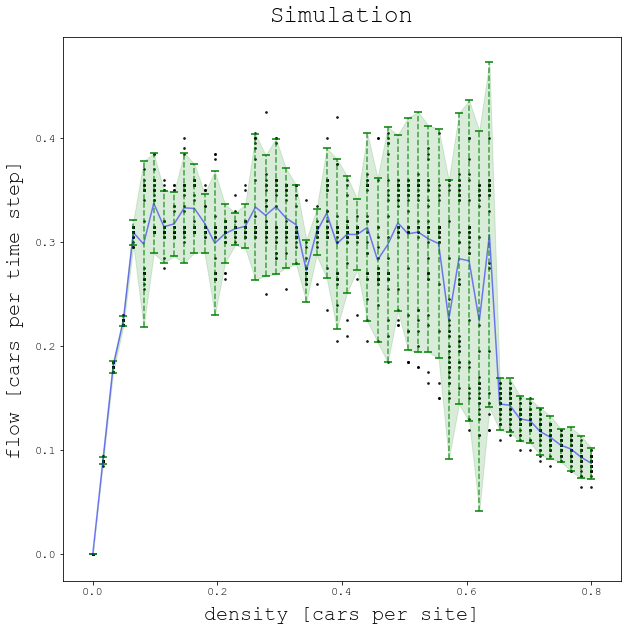

In [20]:
plot_data(Data1)

In [21]:
class MultipleLanes:
    def __init__(self, length = 100, density = 0.2, max_vel = 5, p_slowdown = 0.5, p_changelanes = 1):
        self.n = length
        self.density = density
        self.max_vel = max_vel
        self.p_slowdown = p_slowdown
        self.p_changelanes = p_changelanes
        #state will be represented as a numpy array of 2 x length
        self.state = np.zeros(2*length).reshape(2,length)
        
        #randomly choose the distribution of the density between the two lanes
        if density >= 0.5:
            density1 = (2*density-1)+np.random.random()*(2-2*density)
        else:
            density1 = np.random.random()*2*density
        density2 = 2*density - density1
        
#         print('density = {}'.format(density))
#         print('density1 = {}'.format(density1))
#         print('density2 = {}'.format(density2))
#         print()
        
        #random empty locations for first lane according to density
        init_empty_loc1 = np.random.choice(list(range(length)),int((1-density1)*length), replace=False)
        
        #random empty locations for first lane according to density
        init_empty_loc2 = np.random.choice(list(range(length)),int((1-density2)*length), replace=False)
        for loc in init_empty_loc1:
            self.state[0,loc] = -1
        for loc in init_empty_loc2:
            self.state[1,loc] = -1

    def update2(self): #single-lane updates
        #keep track of the number of flows between n-1 and 0 for this simulation step
        flows = 0
        
        #move cars
        new_state = np.array([-1]*(2*self.n)).reshape(2,self.n)
        for i in range(self.n):
            for j in range(2): #for each lane
                if self.state[j,i] >= 0:
                    if i+self.state[j,i] >= self.n:
                        flows+=1
                    new_state[j,int((i+self.state[j,i])%self.n)]=self.state[j,i]
        self.state = new_state
        
        
        #updating velocities
        for i in range(self.n):
            for j in range(2):
                if self.state[j,i] >= 0:
                    #variable of the new vel that contains copy of current velocity that will be updated by rules 1-4
                    new_vel = self.state[j,i]

                    #rule 1 (I only check for the distance between the current and next car in rule 2)
                    if self.state[j,i] < self.max_vel:
                        new_vel+=1

                    #rule 2
                    #check distance
                    distance = self.max_vel # assume there's enough space to go at max_vel 
                    for d in range(1,self.max_vel+1): #check for all cells between the next and the one at distance max_vel
                        if self.state[j,int((i+d)%self.n)] != -1:
                        #if car is found d steps ahead, update distance to d-1
                            distance = d-1
                            #break the loop because you don't care about the next potential cars ahead
                            break
                    if new_vel > distance:
                        #slowdown to make sure you don't crash (if necessary)
                        new_vel = distance

                    #rule 3
                    if new_vel >= 1:
                        if np.random.random() < self.p_slowdown:
                            #randomly slowing down
                            new_vel -=1

                    #update velocity of car
                    self.state[j,i] = new_vel 
                
        return flows/2 #return the number of flows in the update step (this value is 0, 1, or 2)
    
    def update1(self):
        new_state = np.array([-1]*(2*self.n)).reshape(2,self.n)

        #changing lanes and updating velocities 
        for i in range(self.n):
            for j in range(2):
                if self.state[j,i] >= 0:
                    #changing lanes

                    #LANE1
                    v = int(self.state[j,i])
                    l = v+1 #v+1
                    l_0 = v+1 #v+1
                    l_0back = self.max_vel #v_max

                    #l
                    gapl = 0
                    for d in range(1,v+3):
                        if self.state[j,int((i+d)%self.n)] !=-1:
                            gapl = d-1
                            break
                        if d == v+2:
                            gapl = d

                    #l_0
                    gapl_0 = 0
                    for d in range(1,v+3):
                        if self.state[j-1,int((i+d)%self.n)] != -1:
                            gapl_0 = d-1
                            break
                        if d == v+2:
                            gapl_0 = d

                    #l_0back

                    gapl_0back = 0
                    for d in range(1,self.max_vel+2):
                        if self.state[j-1,int((i-d)%self.n)] !=-1:
                            gapl_0back = d-1
                            break
                        if d == self.max_vel+1:
                            gapl_0back = d

                    #Check if changing lane critiera is satisfied
                    
                    
                    if gapl < l and gapl_0 > l_0 and gapl_0back > l_0back and self.state[j-1,i] == -1:
                        if np.random.random() <= self.p_changelanes:
#                             print("CHANGING LANES: CAR AT POSITION {},{} MOVING".format(j,i))
                            self.state[j,i],self.state[j-1,i] = -1, self.state[j,i]

    def update(self):
        self.update1()
        f = self.update2()
        return f

    def display(self):
        for j in range(2):
            print(''.join('.' if x==-1 else str(int(x)) for x in self.state[j,:]))
           

In [22]:
multilane = MultipleLanes()
multilane.display()

0.....00.........00..........0..0......0...0........0..00.......0...........0....0..................
0.00..0.0......0.0.00.....0.000...0.............00..0..00.....0.............0..0....00.....0...0....


In [23]:
for i in range(1000):
    multilane.update()
    
for i in range(10):
    print(multilane.update())
    multilane.display()
    print()

0.5
1.1.......3...........4.......................00..01..1...2......3....0......3...1..2.....1..0.0.1..
0..1...0.1................5...........4............001....3........0.1.0.......0000......1..1.1..0.0

0.0
.0.2.........4............5....................1..1.1..2....3.......0.0.........1.2...2....0.0.0..2.
1...2..1..1....................5..........2...0....00.2......4.....0..01.......0000.......2..1.0.0.0

0.5
00...3...........4.............4................1..0.1...2.....4....0.0..........2..2...1..0.0.0....
.1....1.1..1........................4.......0.0....00...3........1.1..1.1......0000.........0.00.1.1

0.5
00......4............5.............4.............0.0..1....3.......01.1............2..2..0.0.0.0....
0.2....1.2..1...........................3...0.1....01......4......0.2..0.1.....0001.........0.01..1.

0.0
01..........5.............5............4.........1.1...1......3....1.0.1.......1.....2..01.0.0.0....
1...2...1..1.2.............................01..1...0.2.........2..0

In [24]:
Data2 = collect_data(multilane = True)

sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane
sim is multilane


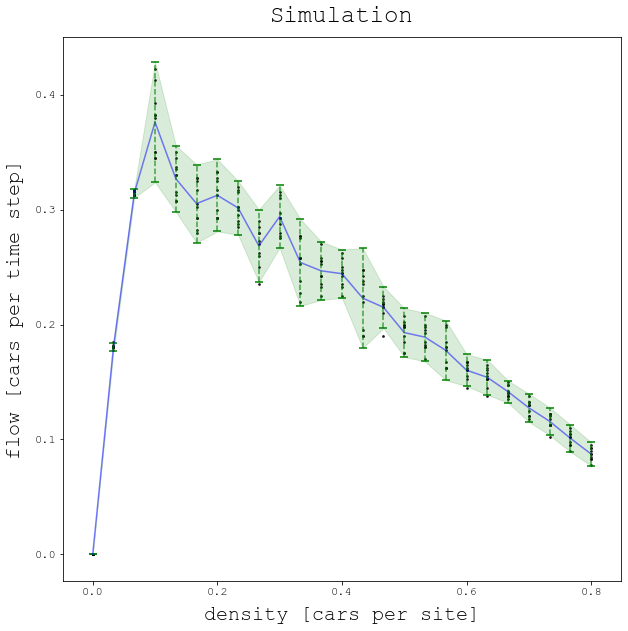

In [25]:
plot_data(Data2)

IndexError: index 25 is out of bounds for axis 0 with size 25

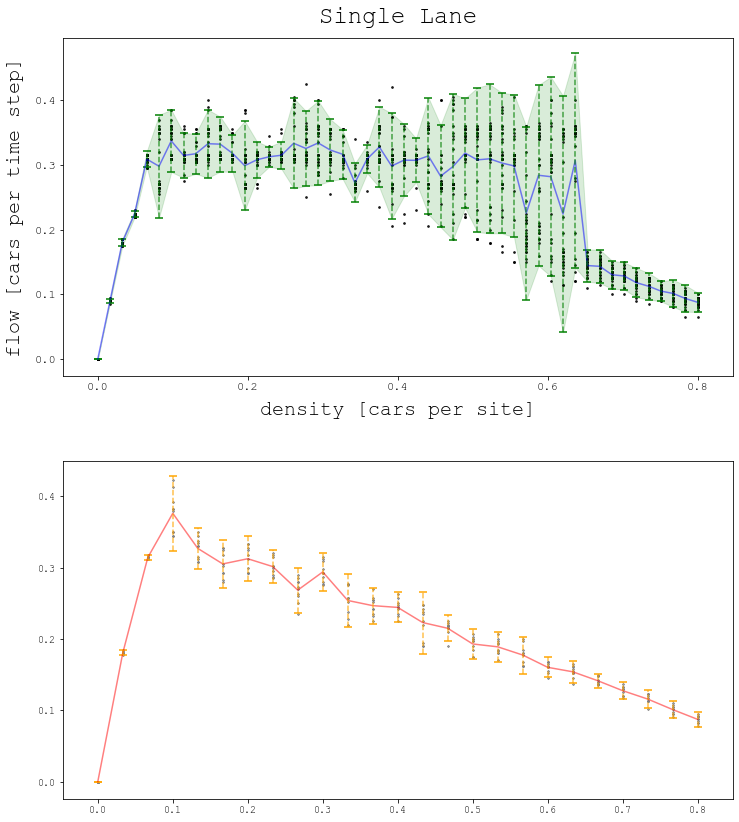

In [26]:
plt.figure(figsize=(12,14))
tscattered = Data1['densities_datapoints']
flows = Data1['flow_datapoints']
t = Data1['densities']
flow_avg = Data1['flow_avg']
confints = Data1['confints']

tscattered2 = Data2['densities_datapoints']
flows2 = Data2['flow_datapoints']
t2 = Data2['densities']
flow_avg2 = Data2['flow_avg']
confints2 = Data2['confints']

#scatter plot
plt.subplots_adjust(hspace=0.25)
plt.subplot(2,1,1)
plt.scatter(tscattered,flows, color ="black", s=3,alpha=0.8)
plt.plot(t,flow_avg, color ="blue",alpha =0.5)
for j in range(len(confints)):
    plt.plot([t[j],t[j]],confints[j], color = "green",linestyle="dashed",alpha = 0.7)
    plt.scatter([t[j],t[j]],confints[j], color = "green", marker = "_", s=80)
plt.fill_between(t,confints[:,0], confints[:,1], color = "green",alpha=0.15)

plt.yticks([0,.1,.2,.3,.4])
plt.xticks([0,.2,.4,.6,.8])
plt.ylabel('flow [cars per time step]',labelpad=10)
plt.xlabel('density [cars per site]',labelpad=10)
plt.title('Single Lane',pad=15)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Courier New"
plt.rcParams["font.size"] = "10"

plt.subplot(2,1,2)
plt.scatter(tscattered2,flows2, color ="gray", s=3,alpha=0.8, marker = 'x')
plt.plot(t2,flow_avg2, color ="red",alpha =0.5)
for j in range(len(confints)):
    plt.plot([t2[j],t2[j]],confints2[j], color = "orange",linestyle="dashed",alpha = 0.7)
    plt.scatter([t2[j],t2[j]],confints2[j], color = "orange", marker = "_", s=80)
plt.fill_between(t2,confints2[:,0], confints2[:,1], color = "green",alpha=0.15)

#     plt.plot(t,confints[:,1], color = "green")
plt.yticks([0,.1,.2,.3,.4])
plt.xticks([0,.2,.4,.6,.8])
plt.ylabel('flow [cars per time step]',labelpad=10)
plt.xlabel('density [cars per site]',labelpad=10)
plt.title('Multiple Lane',pad=15)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Courier New"
plt.rcParams["font.size"] = "10"
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.25)
plt.plot(t,flow_avg, color ="black",alpha =0.5, label = "Single Lane")
plt.fill_between(t,confints[:,0], confints[:,1], color = "black",alpha=0.15)
plt.plot(t2,flow_avg2, color ="red",alpha =0.5, label = "Multiple Lane")
plt.fill_between(t2,confints2[:,0], confints2[:,1], color = "red",alpha=0.15)

#     plt.plot(t,confints[:,1], color = "green")
plt.yticks([0,.1,.2,.3,.4])
plt.xticks([0,.2,.4,.6,.8])
plt.ylabel('flow [cars per time step]',labelpad=10)
plt.xlabel('density [cars per site]',labelpad=10)
plt.title('Single Lane vs. Multiple Lane',pad=15)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Courier New"
plt.rcParams["font.size"] = "18"
plt.legend()
plt.show()

In [ ]:
class TrafficSimulation:
    def __init__(self, length = 100, density = 0.2, max_vel = 5, p_slowdown = 0.5, p_changelanes = 1, num_lanes = 1, left_bias = 0.5):
        self.n = length
        self.density = density
        self.max_vel = max_vel
        self.num_lanes = num_lanes
        self.left_bias = left_bias
        self.p_slowdown = p_slowdown
        self.p_changelanes = p_changelanes
        #state will be represented as a numpy array of num_lanes x length
        self.state = np.zeros(num_lanes*length).reshape(num_lanes,length)
        
        #randomly choose the distribution of the density between the two lanes
        lane_densities = np.array([np.random.random() for _ in range(num_lanes)])
        lane_densities = lane_densities*num_lanes*density/sum(lane_densities)
        
        for d in range(num_lanes):
            lane_d = lane_densities[d]
            init_empty_loc = np.random.choice(list(range(length)),int((1-lane_d)*length), replace=False)
            for loc in init_empty_loc:
                self.state[d,loc] = -1
        
    #check whether there's a neighboring car
    def have_neighbor(self, lane = 0, pos = 0, direction = "left"):
        if direction == "left":
            if lane == 0:
                return True
            else:
                if self.state[lane-1,pos] != -1:
                    return True
                else:
                    return False
        elif direction == "right":
            if lane == self.num_lanes-1:
                return True
            else:
                if self.state[lane+1,pos] != -1:
                    return True
                else:
                    return False
                
    #looking ahead or behind for the next car (look up to max_vel + 1) and return the gap found
    def look_for_car(self, lane = 0, pos = 0, direction = 1):
        if lane < 0 or lane >= self.num_lanes:
            return 0
        gap = 0
        for d in range(1,self.max_vel+2):
            if self.state[lane,int((pos+d*direction)%self.n)] != -1:
                gap = d-1
                break
            if d == self.max_vel+1:
                gap = d
        return gap
    
    def criteria_lanes(self,j,i,gaps, direction = 'left'):
        v = int(self.state[j,i])
        l = v+1
        l_0 = v+1 
        l_0back = self.max_vel 
        return gaps["l"] < l and gaps['l_0_'+direction] > l_0 and gaps['l_0back_'+direction] > l_0back and not self.have_neighbor(j,i,direction)
           
    #changing lanes
    def update1(self):
        new_state = np.array([-1]*(self.num_lanes*self.n)).reshape(self.num_lanes,self.n)

        for j in range(self.num_lanes):
            for i in range(self.n):
                if self.state[j,i] >= 0:
                    #changing lanes

                    #checking gaps and storing in dictionary
                    gaps = {'l':self.look_for_car(j,i,1),
                            'l_0_left':self.look_for_car(j-1,i,1),
                            'l_0_right':self.look_for_car(j+1,i,1),
                            'l_0back_left':self.look_for_car(j-1,i,-1),
                            'gapl_0back_right':self.look_for_car(j+1,i,-1)}

                    if np.random.random() <= self.left_bias:
                        checkfirst = 'left'
                        checksecond = 'right'
                    else:
                        checkfirst = 'right'
                        checksecond = 'left'
                        
                    if self.criteria_lanes(j,i,gaps,checkfirst):
                        if np.random.random() <= self.p_changelanes:
                            print("CHANGING LANES: CAR AT POSITION {},{} MOVING {}".format(j,i,checkfirst))
                            self.state[j,i],self.state[j-1,i] = -1, self.state[j,i]
                    elif self.criteria_lanes(j,i,gaps,checksecond):
                        if np.random.random() <= self.p_changelanes:
                            print("CHANGING LANES: CAR AT POSITION {},{} MOVING {}".format(j,i,checksecond))
                            self.state[j,i],self.state[j-1,i] = -1, self.state[j,i]


    def update2(self): #single-lane updates
        #keep track of the number of flows between n-1 and 0 for this simulation step
        flows = 0
        
        #move cars
        new_state = np.array([-1]*(self.num_lanes*self.n)).reshape(self.num_lanes,self.n)
        for j in range(self.num_lanes): #for each lane
            for i in range(self.n): 
                if self.state[j,i] >= 0:
                    if i+self.state[j,i] >= self.n:
                        flows+=1
                    new_state[j,int((i+self.state[j,i])%self.n)]=self.state[j,i]
        self.state = new_state
        
        
        #updating velocities
        for j in range(self.num_lanes):
            for i in range(self.n):
                if self.state[j,i] >= 0:
                    #variable of the new vel that contains copy of current velocity that will be updated by rules 1-4
                    new_vel = self.state[j,i]

                    #rule 1 (I only check for the distance between the current and next car in rule 2)
                    if self.state[j,i] < self.max_vel:
                        new_vel+=1

                    #rule 2
                    #check distance
                    distance = self.max_vel # assume there's enough space to go at max_vel 
                    for d in range(1,self.max_vel+1): #check for all cells between the next and the one at distance max_vel
                        if self.state[j,int((i+d)%self.n)] != -1:
                        #if car is found d steps ahead, update distance to d-1
                            distance = d-1
                            #break the loop because you don't care about the next potential cars ahead
                            break
                    if new_vel > distance:
                        #slowdown to make sure you don't crash (if necessary)
                        new_vel = distance

                    #rule 3
                    if new_vel >= 1:
                        if np.random.random() < self.p_slowdown:
                            #randomly slowing down
                            new_vel -=1

                    #update velocity of car
                    self.state[j,i] = new_vel 
                
        return flows/self.num_lanes #return the number of flows in the update step (this value is 0, 1, or 2)

    def update(self):
        self.update1()
        f = self.update2()
        return f

    def display(self):
        for j in range(self.num_lanes):
            print(''.join('.' if x==-1 else str(int(x)) for x in self.state[j,:]))